In [1]:
from numpy import *
from matplotlib.pyplot import *

from sys import path
from os.path import abspath
path.append(abspath('..'))
from crnpy.colors import cyan,yellow


from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

from glob import glob
from os import system

def load(pattern) :
    '''load image stack from pattern'''
    
    channel_names = ['CFP','YFP','RFP']
    channels = []
    
    for name in channel_names :
        paths = glob('{}*{}*.tif'.format(pattern,name))
        channels += [ array([ imread(path) for path in sort(paths) ]) ]
    
    return stack(channels,axis=-1)[:-1].astype(float)


def generate_frame(data,t):
    '''save frame to disk'''
    
    plot(x,data[t,...,yfp].T,color='gold',alpha=0.1)
    plot(x,data[t,...,cfp].T,color='darkcyan',alpha=0.1)
    
    y = data[t,...,yfp]
    f = regressor.fit(X[~isnan(y)].reshape(-1,1),y[~isnan(y)].reshape(-1,1))
    plot(x,f.predict(x.reshape(-1,1)),color='k',linewidth=3)

    y = data[t,...,cfp]
    f = regressor.fit(X[~isnan(y)].reshape(-1,1),y[~isnan(y)].reshape(-1,1))
    plot(x,f.predict(x.reshape(-1,1)),color='k',linewidth=3)

    savefig(str(t).zfill(4)+'.png')
    close()


def create_animation(file_name):
    '''execute system commands to create animation from frames'''
    system('convert -delay 10 -loop 0 *.png {}.gif'.format(file_name))
    system('rm *.png')
    
    
def sigmoid(x) :
    return 1.0/(1.0+exp(-x))


def features(x,degree=3) :
    x = squeeze(x)
    fx = [ sigmoid(sigma*(x-mu)) for mu in linspace(0.25,.75,num=degree) for sigma in [-20,20] ]
    return stack(fx,axis=-1)

regressor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])

In [80]:
data = load('C12100C637/')
n_frames,height,width,n_channels = data.shape
x,t = linspace(0,1,num=width),linspace(0,24,num=n_frames)

xx,tt = meshgrid(x,t)
X,_ = meshgrid(x,linspace(0,1,num=height))
cfp,yfp,rfp = 0,1,2

# rfp filtering
threshold = 25000
mask = data[-1,...,rfp] < threshold
mask = stack([[ mask for _ in range(n_frames) ]
                for _ in range(n_channels) ],axis=-1)

data[mask] = NaN

In [81]:
f = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])
g = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])

fs,gs = [],[]
for t in range(n_frames):

    y = data[t,...,yfp]
    f.fit(X[~isnan(y)].reshape(-1,1),y[~isnan(y)].reshape(-1,1))
    
    y = data[t,...,cfp]
    g.fit(X[~isnan(y)].reshape(-1,1),y[~isnan(y)].reshape(-1,1))
    
    fs += [f.predict(x.reshape(-1,1))]
    gs += [g.predict(x.reshape(-1,1))]
    
env = stack([fs,gs],axis=-1)

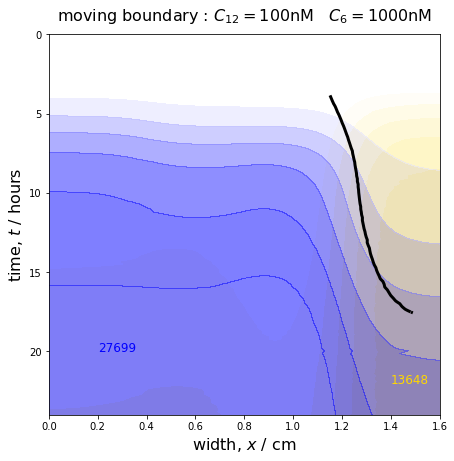

In [79]:
figure(figsize=(7,7))
title(r'moving boundary : $C_{12}=100$nM   $C_{6} = 1000$nM',y=1.02,fontsize=16)

contourf(1.6*xx,tt,env[...,0],cmap='yellow',alpha=1,vmin=4000,vmax=20000)
contourf(1.6*xx,tt,env[...,1],cmap='cyan',alpha=0.5,vmin=4000,vmax=20000)

text(1.4,22,'{:.0f}'.format(amax(env[...,0])),color='gold',fontsize=12)
text(0.2,20,'{:.0f}'.format(amax(env[...,1])),color='blue',fontsize=12)

difference = env[...,0].T-env[...,1].T
difference[(env[...,cfp].T<1500)|(env[...,cfp].T>13400)] = NaN
contour(1.6*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

xlabel('width, $x$ / cm',fontsize=16)
ylabel('time, $t$ / hours',fontsize=16);
gca().invert_yaxis()

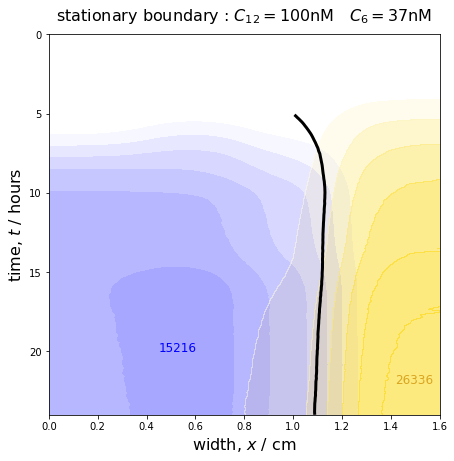

In [91]:

figure(figsize=(7,7))
title(r'stationary boundary : $C_{12}=100$nM   $C_{6} = 37$nM',y=1.02,fontsize=16)

contourf(1.6*xx,tt,env[...,1],cmap='cyan',alpha=1,vmin=4000,vmax=20000)
contourf(1.6*xx,tt,env[...,0],cmap='yellow',alpha=0.5,vmin=4000,vmax=20000)


text(1.42,22,'{:.0f}'.format(amax(env[...,0])),color='goldenrod',fontsize=12)
text(0.45,20,'{:.0f}'.format(amax(env[...,1])),color='blue',fontsize=12)

difference = env[...,0].T-env[...,1].T
difference[(env[...,cfp].T<1500)|(env[...,cfp].T>13400)] = NaN
contour(1.6*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

xlabel('width, $x$ / cm',fontsize=16)
ylabel('time, $t$ / hours',fontsize=16);
gca().invert_yaxis()

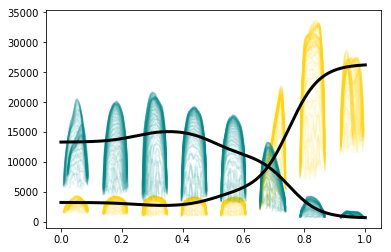

In [92]:
t =-1
plot(x,data[t,...,yfp].T,color='gold',alpha=0.1);
plot(x,data[t,...,cfp].T,color='darkcyan',alpha=0.1);

from sklearn.linear_model import BayesianRidge

def features(x,degree=3) :
    x = squeeze(x)
    fx = [ sigmoid(sigma*(x-mu)) for mu in linspace(0.25,.75,num=degree) for sigma in [-20,20] ]
    return stack(fx,axis=-1)

regressor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])

y = data[t,...,yfp]
f = regressor.fit(X[~isnan(y)].reshape(-1,1),y[~isnan(y)].reshape(-1,1))
plot(x,f.predict(x.reshape(-1,1)),color='k',linewidth=3)

y = data[t,...,cfp]
f = regressor.fit(X[~isnan(y)].reshape(-1,1),y[~isnan(y)].reshape(-1,1))
plot(x,f.predict(x.reshape(-1,1)),color='k',linewidth=3)

In [2]:
# loading data
for data_path in glob('*/') :

    data = load(data_path+'/')
    n_frames,height,width,n_channels = data.shape
    x = linspace(0,1,num=width)
    X,_ = meshgrid(x,linspace(0,1,num=height))
    cfp,yfp,rfp = 0,1,2

    # rfp filtering
    threshold = 25000
    mask = data[-1,...,rfp] < threshold
    mask = stack([[ mask for _ in range(n_frames) ]
                    for _ in range(n_channels) ],axis=-1)

    data[mask] = NaN

    for t in range(n_frames) :
        generate_frame(data,t)
    create_animation(data_path.replace('/',''))

/home/gszep/.local/lib/python2.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/gszep/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
